# 深度 $Q$-学习

在此 notebook 中，我们将构建一个可以通过强化学习学会玩游戏的神经网络。具体而言，我们将使用 $Q$-学习训练智能体玩一个叫做 [Cart-Pole](https://gym.openai.com/envs/CartPole-v0) 的游戏。在此游戏中，小车上有一个可以自由摆动的杆子。小车可以向左和向右移动，目标是尽量长时间地使杆子保持笔直。

![Cart-Pole](assets/cart-pole.jpg)

我们可以使用 [OpenAI Gym](https://github.com/openai/gym) 模拟该游戏。首先，我们看看 OpenAI Gym 的原理。然后，我们将训练智能体玩 Cart-Pole 游戏。

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


In [ ]:
[2018-01-22 23:10:02,350] Making new env: CartPole-v1


Number of possible actions: 2


我们通过 `env` 与模拟环境互动。你可以通过 `env.action_space.n`查看有多少潜在的动作，并且使用 `env.action_space.sample()` 获得随机动作。向 `env.step` 传入动作（用整数表示）将生成模拟环境的下一个步骤。所有 Gym 游戏基本都是这样。

在 Cart-Pole 游戏中有两个潜在动作，即使小车向左或向右移动。因此我们可以采取两种动作，分别表示为 0 和 1。

运行以下代码以与环境互动。

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

我们可以查看动作和奖励：

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


当杆子倾斜角度超过特定的角度之后，游戏就会重置。当游戏还在运行时，在每一步都会返回奖励 1.0。游戏运行时间越久，我们获得的奖励就越多。网络的目标是通过使杆子保持垂直状态最大化奖励。为此，它将使小车向左和向右移动。

## $Q$-网络

为了跟踪动作值，我们将使用接受状态 $s$ 作为输入的神经网络。输出将是每个潜在动作的 $Q$ 值（即输出是_输入状态 $s$ 对应的_**所有**动作值 $Q(s,a)$。

<img src="assets/q-network.png" width=550px>

对于这个 Cart-Pole 游戏，状态有四个值：小车的位置和速度，杆子的位置和速度。因此，该神经网络有**四个输入**（状态中的每个值对应一个输入）和**两个输出**（每个潜在动作对应一个输出）。

正如在这节课所讨论的，为了实现训练目标，我们首先将利用状态  $s$ 提供的背景信息选择动作 $a$，然后使用该动作模拟游戏。这样将会获得下个状态 $s'$ 以及奖励 $r$。这样我们就可以计算 $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$。然后，我们通过最小化 $(\hat{Q}(s,a) - Q(s,a))^2$ 更新权重。

下面是 $Q$ 网络的一种实现。它使用两个包含 ReLU 激活函数的完全连接层。两层似乎很好，三层可能更好，你可以随意尝试。

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 经验回放

强化学习算法可能会因为状态之间存在关联性而出现稳定性问题。为了在训练期间减少关联性，我们可以存储智能体的经验，稍后从这些经验中随机抽取一个小批量经验进行训练。 

在以下代码单元格中，我们将创建一个 `Memory` 对象来存储我们的经验，即转换 $<s, a, r, s'>$。该存储器将设有最大容量，以便保留更新的经验并删除旧的经验。然后，我们将随机抽取一个小批次转换 $<s, a, r, s'>$ 并用它来训练智能体。

我在下面实现了 `Memory` 对象。如果你不熟悉 `deque`，其实它是一个双端队列。可以将其看做在两端都有开口的管子。你可以从任何一端放入物体。但是如果放满了，再添加物体的话将使物体从另一端被挤出。这是一种非常适合内存缓冲区的数据结构。

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-学习训练算法

我们将使用以下算法训练网络。对于此游戏，目标是使杆子在 195 帧内都保持垂直状态。因此当我们满足该目标后，可以开始新的阶段。如果杆子倾斜角度太大，或者小车向左或向右移动幅度太大，则游戏结束。当游戏结束后，我们可以开始新的阶段。现在，为了训练智能体：

* 初始化存储器 $D$
* 使用随机权重初始化动作值网络 $Q$
* **对于**阶段 $\leftarrow 1$ **到** $M$，**执行**以下操作
  * 观察 $s_0$
  * **对于** $t \leftarrow 0$ **到** $T-1$，**执行**以下操作
     * 对于概率 $\epsilon$，选择随机动作 $a_t$，否则选择 $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * 在模拟器中执行动作 $a_t$，并观察奖励 $r_{t+1}$ 和新状态 $s_{t+1}$
     * 将转换 $<s_t, a_t, r_{t+1}, s_{t+1}>$ 存储在存储器 $D$ 中
     * 从 $D$: $<s_j, a_j, r_j, s'_j>$ 中随机抽取小批量经验
     * 如果阶段在 $j+1$ 时结束，设为 $\hat{Q}_j = r_j$，否则设为 $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * 创建梯度下降步骤，损失为 $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

建议你花时间扩展这段代码，以实现我们在这节课讨论的一些改进之处，从而包含固定 $Q$ 目标、双 DQN、优先回放和/或对抗网络。

## 超参数

对于强化学习，比较难的一个方面是超参数很大。我们不仅要调整网络，还要调整模拟环境。

In [6]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## 填充经验存储器

我们在下面重新初始化了模拟环境并提前填充了存储器。智能体正在采取随机动作，并将转换存储在存储器中。这样可以帮助智能体探索该游戏。

In [8]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## 训练

下面我们将训练智能体。

In [9]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 12.0 Training loss: 1.0489 Explore P: 0.9988
Episode: 2 Total reward: 12.0 Training loss: 1.0782 Explore P: 0.9976
Episode: 3 Total reward: 14.0 Training loss: 1.0884 Explore P: 0.9962
Episode: 4 Total reward: 32.0 Training loss: 1.0761 Explore P: 0.9931
Episode: 5 Total reward: 38.0 Training loss: 1.2016 Explore P: 0.9894
Episode: 6 Total reward: 44.0 Training loss: 1.0505 Explore P: 0.9851
Episode: 7 Total reward: 11.0 Training loss: 1.0589 Explore P: 0.9840
Episode: 8 Total reward: 14.0 Training loss: 1.2370 Explore P: 0.9826
Episode: 9 Total reward: 44.0 Training loss: 0.9883 Explore P: 0.9784
Episode: 10 Total reward: 11.0 Training loss: 1.2442 Explore P: 0.9773
Episode: 11 Total reward: 19.0 Training loss: 0.9841 Explore P: 0.9755
Episode: 12 Total reward: 24.0 Training loss: 1.1376 Explore P: 0.9731
Episode: 13 Total reward: 13.0 Training loss: 1.2569 Explore P: 0.9719
Episode: 14 Total reward: 11.0 Training loss: 1.2145 Explore P: 0.9708
Episode: 15 Tot

## 可视化训练结果

我们在下面绘制了每个阶段的总奖励。滚动平均值用蓝色表示。

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

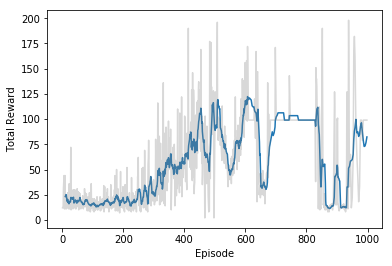

In [12]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [ ]:
Text(0,0.5,'Total Reward')




![png](output_21_1.png)


## 玩街机游戏

Cart-Pole 是一个非常简单的游戏。但是，可以使用同一模型训练智能体玩非常复杂的游戏，例如 Pong 或 Space Invaders。你需要使用卷积层从屏幕图片上获取状态，而不是采取在此游戏中使用的状态。

![Deep Q-Learning Atari](assets/atari-network.png)

作为一项挑战，我将请你来使用深度 Q 学习训练智能体玩街机游戏。为了获得指导，请参阅以下原始论文：http://www.davidqiu.com:8888/research/nature14236.pdf。